<a href="https://colab.research.google.com/github/EthanMcFarlin/ait-deep-learning-assessment-6/blob/main/Ethan_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [68]:
# The data— obtained from Gutenberg.org— consists of the full source text for two pieces of classic literature: Bram Stoker's 1897 novel "Dracula" 
# and Herman Melville's 1851 novel "Moby-Dick; or, The Whale".

# dracula: https://www.gutenberg.org/cache/epub/345/pg345.txt
# moby dick: https://www.gutenberg.org/files/2701/2701-0.txt

# Source text is read and saved to a local variable using the library urlopen
dracula = urlopen("https://www.gutenberg.org/cache/epub/345/pg345.txt").read().decode('utf-8').replace('\r\n', ' ')
moby_dick = urlopen("https://www.gutenberg.org/files/2701/2701-0.txt").read().decode('utf-8').replace('\r\n', ' ')


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

Dracula Length: 865720
Moby Dick Length: 1238355


<Axes: >

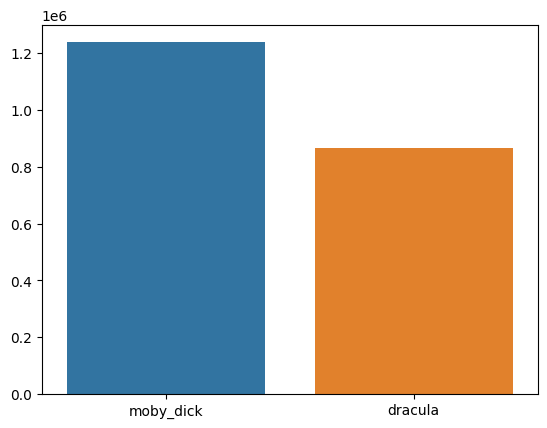

In [36]:
# Total length (in characters) of Dracula
dracula_len = sum(len(word) for word in dracula)
print("Dracula Length: " + str(dracula_len))

# Total length (in characters) of Moby Dick
moby_dick_len = sum(len(word) for word in moby_dick)
print("Moby Dick Length: " +  str(moby_dick_len))

# Visualization of text lengths using a Seaborn Counterplot
countplot_data = {"moby_dick": moby_dick_len, "dracula": dracula_len}
countplot_keys = list(countplot_data.keys())
countplot_values = [countplot_data[key] for key in countplot_keys]
# Data is stored in a Python dictionary
sns.barplot(x = countplot_keys, y = countplot_values)


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [69]:
# Initializing the sequence length to 60
sequence_length = 60

# Sorting and counting distinct characters in either text
dracula_unique_characters = sorted(set(dracula))
moby_dick_unique_characters = sorted(set(moby_dick))
combined_unique_characters = sorted(set(dracula + moby_dick))

# Creating a set of (i) character to index and (ii) index to character dictionaries for Dracula
dracula_char_indices = dict((c, i) for i, c in enumerate(dracula_unique_characters))
dracula_indices_char = dict((i, c) for i, c in enumerate(dracula_unique_characters))
print("Dracula indices to char dictionary:", dracula_indices_char)

# Creating a set of (i) character to index and (ii) index to character dictionaries for Moby Dick
moby_dick_char_indices = dict((c, i) for i, c in enumerate(moby_dick_unique_characters))
moby_dick_indices_char = dict((i, c) for i, c in enumerate(moby_dick_unique_characters))
print("Moby Dick indices to char dictionary:", moby_dick_indices_char)

# Building combined dictionaries for the two texts
combined_char_indices = dict((c, i) for i, c in enumerate(combined_unique_characters))
combined_indices_char = dict((i, c) for i, c in enumerate(combined_unique_characters))
print("Combined indices to char dictionary:", combined_indices_char)

# Initializing variables using in the one-hot encodings
step_size = 10
dracula_sentences = []
moby_dick_sentences = []

for i in range(0, len(dracula)-sequence_length, step_size):
    dracula_sentences.append(dracula[i:i+sequence_length])

for i in range(0, len(moby_dick)-sequence_length, step_size):
    moby_dick_sentences.append(moby_dick[i:i+sequence_length])

combined_sentences = dracula_sentences + moby_dick_sentences
print("Length of combined sentences: ", len(combined_sentences))

# Creating input and target data from sentences
x = np.zeros((len(combined_sentences), sequence_length, len(combined_indices_char)))
y = np.zeros((len(combined_sentences), 2), dtype=float)

# Populating the input data with a 1 or 0 respective to author
for i, sentence in enumerate(dracula_sentences):
    for t, char in enumerate(sentence): 
        x[i,t,combined_char_indices[char]] = 1
    y[i][0] = 1

index_offset = len(dracula_sentences)

for i, sentence in enumerate(moby_dick_sentences):
    for t, char in enumerate(sentence): 
        x[i + index_offset, t, combined_char_indices[char]] = 1
    y[i + index_offset][1] = 1

# Outputting the shape of the input and target data
print ("Shape of the input data:", x.shape)
print ("Shape of the target data:", y.shape)

Dracula indices to char dictionary: {0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '=', 28: '>', 29: '?', 30: 'A', 31: 'B', 32: 'C', 33: 'D', 34: 'E', 35: 'F', 36: 'G', 37: 'H', 38: 'I', 39: 'J', 40: 'K', 41: 'L', 42: 'M', 43: 'N', 44: 'O', 45: 'P', 46: 'Q', 47: 'R', 48: 'S', 49: 'T', 50: 'U', 51: 'V', 52: 'W', 53: 'X', 54: 'Y', 55: 'Z', 56: '[', 57: ']', 58: '_', 59: 'a', 60: 'b', 61: 'c', 62: 'd', 63: 'e', 64: 'f', 65: 'g', 66: 'h', 67: 'i', 68: 'j', 69: 'k', 70: 'l', 71: 'm', 72: 'n', 73: 'o', 74: 'p', 75: 'q', 76: 'r', 77: 's', 78: 't', 79: 'u', 80: 'v', 81: 'w', 82: 'x', 83: 'y', 84: 'z', 85: '{', 86: '}', 87: '£', 88: 'à', 89: 'á', 90: 'â', 91: 'æ', 92: 'è', 93: 'é', 94: 'ë', 95: 'ï', 96: 'ô', 97: 'ö', 98: '—', 99: '’', 100: '“', 101: '”', 102: '\ufeff'}
Moby Dick indices to char dictionary: 

## Data splitting
Split the data into train, validate and test sets. Make 

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

## Model training
Train the model and apply early stopping.

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

## Confusion matrix
Calculate and display the confusion matrix.